# Homework 3: Word Embedding

In this exercise, you will work on the skip-gram neural network architecture for Word2Vec. You will be using Keras to train your model. 

The sample code for skip-gram model is given. Your job is to incorporate the tokenizer model that you created in HomeWork-1 to tokenize raw text and turn it into word vectors.

You must complete the following tasks:
1. Read/clean text files
2. Indexing (Assign a number to each word)
3. Create skip-grams (inputs for your model)
4. Create the skip-gram neural network model
5. Visualization
6. Evaluation (Using pre-trained, not using pre-trained)
    (classify topic from 4 categories) 
    
This notebook assumes you have already installed Tensorflow and Keras with python3 and had GPU enabled. If you run this exercise on GCloud using the provided disk image you are all set.

As a reminder,

### Don't forget to shut down your instance on Gcloud when you are not using it ###


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import glob
import re
import random
import collections
import os
import sys
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import GRU, Dropout
from keras.models import load_model
from keras.layers import Embedding, Reshape, Activation, Input, Dense, Masking
from keras.layers.merge import Dot
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import skipgrams
from keras.preprocessing import sequence
from keras import backend as K
from keras.optimizers import Adam


random.seed(42)

Using TensorFlow backend.


## Step 1: Read/clean text files

The given code can be used to processed the pre-tokenzied text file from the wikipedia corpus. In your homework, you must replace those text files with raw text files.  You must use your own tokenizer to process your text files

In [2]:
#Step 1: read the wikipedia text file
cwd = os.getcwd()
with open(cwd+"/corpora/wiki/thwiki_chk.txt") as f:
    raw_text = [] 
    #The text file is already tokenized BUT...
    #we've replaced all the spaces between words, so you have to use your tokenizer.
    raw_text.extend(re.sub(r"\s+","",f.read()))
    #since the wiki file is very large, we will only use 1/20 of the whole wiki file in this homework
    # if you have enough memeory and want to add more training data, please feel free to edit this code
    # to include more data
    raw_text = raw_text[:len(raw_text)//20]

In [3]:
print(raw_text[0:10])

['ห', 'น', '้', 'า', 'ห', 'ล', 'ั', 'ก', 'ว', 'ิ']


In [4]:
# Create a character map
CHARS = [
  '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+',
  ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8',
  '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E',
  'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R',
  'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_',
  'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
  'n', 'o', 'other', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y',
  'z', '}', '~', 'ก', 'ข', 'ฃ', 'ค', 'ฅ', 'ฆ', 'ง', 'จ', 'ฉ', 'ช',
  'ซ', 'ฌ', 'ญ', 'ฎ', 'ฏ', 'ฐ', 'ฑ', 'ฒ', 'ณ', 'ด', 'ต', 'ถ', 'ท',
  'ธ', 'น', 'บ', 'ป', 'ผ', 'ฝ', 'พ', 'ฟ', 'ภ', 'ม', 'ย', 'ร', 'ฤ',
  'ล', 'ว', 'ศ', 'ษ', 'ส', 'ห', 'ฬ', 'อ', 'ฮ', 'ฯ', 'ะ', 'ั', 'า',
  'ำ', 'ิ', 'ี', 'ึ', 'ื', 'ุ', 'ู', 'ฺ', 'เ', 'แ', 'โ', 'ใ', 'ไ',
  'ๅ', 'ๆ', '็', '่', '้', '๊', '๋', '์', 'ํ', '๐', '๑', '๒', '๓',
  '๔', '๕', '๖', '๗', '๘', '๙', '‘', '’', '\ufeff'
]
CHARS_MAP = {v: k for k, v in enumerate(CHARS)}
char = np.array(CHARS)

In [5]:
def create_n_gram_df(df, n_pad):
  """
  Given an input dataframe, create a feature dataframe of shifted characters
  Input:
  df: timeseries of size (N)
  n_pad: the number of context. For a given character at position [idx],
    character at position [idx-n_pad/2 : idx+n_pad/2] will be used 
    as features for that character.
  
  Output:
  dataframe of size (N * n_pad) which each row contains the character, 
    n_pad_2 characters to the left, and n_pad_2 characters to the right
    of that character.
  """
  n_pad_2 = int((n_pad - 1)/2)
  for i in range(n_pad_2):
      df['char-{}'.format(i+1)] = df['char'].shift(i + 1)
      df['char{}'.format(i+1)] = df['char'].shift(-i - 1)
  return df[n_pad_2: -n_pad_2]


def prepare_wiki_feature(raw_text_input):
    """
    Transform the path to a directory containing processed files 
    into a feature matrix and output array
    """
    # we use padding equals 21 here to consider 10 characters to the left
    # and 10 characters to the right as features for the character in the middle
    n_pad = 21
    n_pad_2 = int((n_pad - 1)/2)
    pad = [{'char': ' ', 'target': True}]
    df_pad = pd.DataFrame(pad * n_pad_2)

    df = []

    df.append(pd.DataFrame(  {'char': raw_text_input}))

    df = pd.concat(df)
    # pad with empty string feature
    df = pd.concat((df_pad, df, df_pad))

    # map characters to numbers, use 'other' if not in the predefined character set.
    df['char'] = df['char'].map(lambda x: CHARS_MAP.get(x, 80))

    # Use nearby characters as features
    df_with_context = create_n_gram_df(df, n_pad=n_pad)

    char_row = ['char' + str(i + 1) for i in range(n_pad_2)] + \
             ['char-' + str(i + 1) for i in range(n_pad_2)] + ['char']

    # convert pandas dataframe to numpy array to feed to the model
    x_char = df_with_context[char_row].as_matrix()

    return x_char

#A function for displaying our features in text
def print_features(tfeature,index):
    feature = np.array(tfeature[index],dtype=int).reshape(21,1)
    #Convert to string
    char_list = char[feature]
    left = ''.join(reversed(char_list[10:20].reshape(10))).replace(" ", "")
    center = ''.join(char_list[20])
    right =  ''.join(char_list[0:10].reshape(10)).replace(" ", "")
    word = ''.join([left,' ',center,' ',right])
    print(center + ': ' + word )

## <font color='blue'>Homework Question1:</font>
<font color='blue'>Use your own tokenizer (aka word segmentation model)  to define word boundaries and split the given text file into words.  Capture the screenshot of your code segment that loads the word segmentation model and uses the model to segment the text files. </font>

In [6]:
# TODO#1 
from keras.layers import Conv1D, MaxPooling1D, Embedding, TimeDistributed
from keras.layers import Activation, Dropout, Flatten, Dense, Input,GRU, Bidirectional
#load your word segmentation model here!
def get_your_nn():
    max_features = len(CHARS)+1
    max_len=21
    #replace "pass" with code for your neural net
    input1 = Input(shape=(21,))
    x = Embedding(max_features, 32, input_length=max_len)(input1)
    x = Conv1D(100, 5, strides = 1, padding='same', activation='relu')(x)
    x = TimeDistributed(Dense(5, activation='relu'))(x)
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(),
                loss='binary_crossentropy',
                metrics=['acc'])
    return model


model = get_your_nn()
model.load_weights("/media/kok/New Volume/NLP/nlp_2019/HW5/model_conv1d_nn.h5")
#load weights here/ or alternatively you can also load your entire model

In [7]:
x_char= prepare_wiki_feature(raw_text)
#feel free to edit prepare_wiki_feature if your model has different input format
# As a sanity check, we print out the size of the data.
print(' data shape: ', x_char.shape)

/home/kok/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:40: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/kok/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


 data shape:  (7592023, 21)


In [8]:
def char_to_word(raw_text, y_pred):
    """ add spaces between words in the raw text based on your prediction
    """
    split_text=""
    for char, y in zip(raw_text,y_pred):
        if y == 1:
            split_text+=" "
            split_text+=char
        else:
            split_text+=char
    return split_text.split(" ")

In [9]:
print(x_char)

[[118. 160. 142. ...   1.   1. 135.]
 [160. 142. 135. ...   1.   1. 118.]
 [142. 135. 130. ...   1.   1. 160.]
 ...
 [ 94. 130.   1. ... 131. 118. 119.]
 [130.   1.   1. ... 142. 131.  94.]
 [  1.   1.   1. ... 127. 142. 130.]]


In [20]:
####TOKENIZATION
###THIS MIGHT TAKE ABOUT 10 MINS on feed forward models
y_pred = model.predict(x_char)
prob_to_class = lambda p: 1 if p[0]>=0.5 else 0
y_pred = np.apply_along_axis(prob_to_class,1,y_pred)
#del x_char #clear up some memory

In [21]:
tokens= char_to_word(raw_text, y_pred)
#print out first 100 words for sanity check
print(tokens[0:100])

['', 'หน้า', 'หลักวิกิพีเดีย', 'ดำเนิน', 'การ', 'โดย', 'มูลนิธิวิกิมี', 'เดีย', 'องค์กร', 'ไม่', 'แสวง', 'ผล', 'กำไร', 'ผู้', 'ดำเนิน', 'การ', 'อีก', 'หลาย', 'ได้แก่__NOED', 'ITSECTION__ดาราศาสตร์', 'ดาราศาสตร์', 'คือ', 'วิชาวิทยาศาสตร์', 'ที่', 'ศึกษา', 'วัตถุ', 'ท้อง', 'ฟ้า', '(', 'อาทิ', 'ดาวฤกษ์', 'ดาวเคราะห์', 'ดาวหาง', 'และ', 'ดาราจักร', ')', 'รวม', 'ทั้ง', 'ปรากฏการณ์', 'ทาง', 'ธรรมชาติ', 'ต่างๆ', 'ที่', 'เกิด', 'ขึ้น', 'จาก', 'นอก', 'ชั้น', 'บรรยากาศ', 'ของ', 'โลก', 'โดย', 'ศึกษา', 'เกี่ยว', 'กับ', 'วิวัฒนา', 'การ', 'ลักษณะ', 'ทาง', 'กาย', 'ภาพ', 'ทาง', 'เคมี', 'ทาง', 'อุตุนิยมวิทยา', 'และ', 'การ', 'เคลื่อน', 'ที่', 'ของ', 'วัตถุ', 'ท้อง', 'ฟ้า', 'ตลอด', 'จน', 'ถึง', 'การ', 'กำเนิด', 'และ', 'วิวัฒนาการ', 'ของ', 'เอกภพดาราศาสตร์', 'เป็น', 'หนึ่ง', 'ใน', 'สาขา', 'ของ', 'วิทยาศาสตร์', 'ที่', 'เก่า', 'แก่', 'ที่', 'สุด', 'นัก', 'ดาราศาสตร์', 'ใน', 'วัฒนธรรม', 'โบราณ', 'สังเกตการณ์', 'ดวง']


In [22]:
print("total word count:", len(tokens))

total word count: 1816353


## Step 2: Indexing (Assign a number to each word)

The code below generates an indexed dataset(each word is represented by a number), a dictionary, a reversed dictionary

## <font color='blue'>Homework Question 2:</font>
<font color='blue'>“UNK” is often used to represent an unknown word (a word which does not exist in your dictionary/training set). You can also represent a rare word with this token as well.  How do you define a rare word in your program? Explain in your own words and capture the screenshot of your code segment that is a part of this process</font>

 + <font color='blue'>edit or replace create_index with your own code to set a threshold for rare words and replace them with "UNK"</font>

In [27]:
#step 2:Build dictionary and build a dataset(replace each word with its index)
def create_index(words):
    # TODO#2:edit or replace this function
    word_count = list()
    #use set and len to get the number of unique words
    word_count.extend(collections.Counter(words).most_common(len(set(words))))
    #include a token for unknown word
    #word_count.append(("UNK",0))
    #print out 10 most frequent words
    print(word_count[:10])
    dictionary = dict()
    dictionary["for_keras_zero_padding"] = 0
    for word in word_count:
        if word[1]>1:
            dictionary[word[0]] = len(dictionary)
    dictionary["UNK"]=len(dictionary)
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    data = list()
    for word in words:
        if word in dictionary:
            data.append(dictionary[word])
        else:
            data.append(dictionary["UNK"])
    return data,dictionary, reverse_dictionary

dataset,dictionary, reverse_dictionary=create_index(tokens)


[('ที่', 48410), ('การ', 44724), ('ใน', 43794), ('เป็น', 36821), ('และ', 35591), ('ของ', 34073), ('มี', 30837), ('ได้', 25500), ('"', 18177), (')', 17525)]


In [28]:
print("output sample (dataset):",dataset[:10])
print("output sample (dictionary):",{k: dictionary[k] for k in list(dictionary)[:10]})
print("output sample (reverse dictionary):",{k: reverse_dictionary[k] for k in list(reverse_dictionary)[:10]})

output sample (dataset): [26452, 172, 26452, 276, 2, 17, 7769, 848, 552, 25]
output sample (dictionary): {'for_keras_zero_padding': 0, 'ที่': 1, 'การ': 2, 'ใน': 3, 'เป็น': 4, 'และ': 5, 'ของ': 6, 'มี': 7, 'ได้': 8, '"': 9}
output sample (reverse dictionary): {0: 'for_keras_zero_padding', 1: 'ที่', 2: 'การ', 3: 'ใน', 4: 'เป็น', 5: 'และ', 6: 'ของ', 7: 'มี', 8: 'ได้', 9: '"'}


In [29]:
len(dictionary)

26453

# Step3: Create skip-grams (inputs for your model)
Keras has a skipgrams-generator, the cell below shows us how it generates skipgrams 

## <font color='blue'>Homework Question 3:</font>
<font color='blue'>The negative samples are sampled from sampling_table.  Look through Keras source code to find out how they sample negative samples. Discuss the sampling technique taught in class and compare it to the Keras source code.</font>

ANSWER:
code from keras https://github.com/keras-team/keras-preprocessing/blob/master/keras_preprocessing/sequence.py
def make_sampling_table(size, sampling_factor=1e-5):

gamma = 0.577
rank = np.arange(size)
rank[0] = 1
inv_fq = rank * (np.log(rank) + gamma) + 0.5 - 1. / (12. * rank)
f = sampling_factor * inv_fq

return np.minimum(1., f / np.sqrt(f))

Compare with Euler-Mascheroni constant and 1 to make the result not less than 1.

In [30]:
# Step 3: Create data samples
vocab_size = len(dictionary)
skip_window = 3       # How many words to consider left and right.

sample_set= dataset[:10]
sampling_table = sequence.make_sampling_table(vocab_size)
#TO DO#3 check out keras source code and find out  their sampling technique works
couples, labels = skipgrams(sample_set, vocab_size, window_size=skip_window, sampling_table=sampling_table)
word_target, word_context = zip(*couples)
word_target = np.array(word_target, dtype="int32")
word_context = np.array(word_context, dtype="int32")

print(couples, labels)

for i in range(8):
    print(reverse_dictionary[couples[i][0]],reverse_dictionary[couples[i][1]])
#They sample by use the words between [i-skip_window,i+1+skip_window], i is the index of the center word.
#As the output show pair of positive(1) and negative(0) with the center word.

[[7769, 552], [7769, 12428], [26452, 276], [26452, 2], [26452, 172], [7769, 2], [26452, 6102], [7769, 15758], [7769, 848], [7769, 11468], [7769, 17], [26452, 19949], [7769, 276], [26452, 276], [26452, 26452], [7769, 18593], [26452, 14310], [26452, 324], [26452, 20433], [7769, 10962], [26452, 17], [7769, 4535], [26452, 26452], [26452, 542], [26452, 172], [26452, 22318], [7769, 25], [26452, 6588]] [1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]
มูลนิธิวิกิมี องค์กร
มูลนิธิวิกิมี ชื้อ
UNK ดำเนิน
UNK การ
UNK หน้า
มูลนิธิวิกิมี การ
UNK อาเจียน
มูลนิธิวิกิมี ราชสักการะ


# Step 4: create the skip-gram model
## <font color='blue'>Homework Question 4:</font>
 <font color='blue'>Q4:  In your own words, discuss why Sigmoid is chosen as the activation function in the  skip-gram model.</font>
 
 ANSWER::
 Because sigmoid function map output to be between [0,1] it match for positive(1) and negative(0) sampling as skip-gram wish.

In [31]:
#reference: https://github.com/nzw0301/keras-examples/blob/master/Skip-gram-with-NS.ipynb
dim_embedddings = 32
V= len(dictionary)

#step1: select the embedding of the target word from W
w_inputs = Input(shape=(1, ), dtype='int32')
w = Embedding(V, dim_embedddings)(w_inputs)

#step2: select the embedding of the context word from C
c_inputs = Input(shape=(1, ), dtype='int32')
c  = Embedding(V, dim_embedddings)(c_inputs)

#step3: compute the dot product:c_k*v_j
o = Dot(axes=2)([w, c])
o = Reshape((1,), input_shape=(1, 1))(o)

#step4: normailize dot products into probability
o = Activation('sigmoid')(o)
#TO DO#4 Question: Why sigmoid?

SkipGram = Model(inputs=[w_inputs, c_inputs], outputs=o)
SkipGram.summary()
opt=Adam(lr=0.01)
SkipGram.compile(loss='binary_crossentropy', optimizer=opt)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 32)        846496      input_10[0][0]                   
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 1, 32)        846496      input_11[0][0]                   
__________________________________________________________________________________________________
dot_1 (Dot

In [32]:
for _ in range(5):
    prev_i=0
    for i in range(len(dataset)//100000):
        data, labels = skipgrams(sequence=dataset[prev_i:i+100000], vocabulary_size=V, window_size=2, negative_samples=4.)
        x = [np.array(x) for x in zip(*data)]
        y = np.array(labels, dtype=np.int32)
        if x:
            loss = SkipGram.train_on_batch(x, y)
        
        print(loss,i*100000)


0.69315255 0
0.69311297 100000
0.6930566 200000
0.69296044 300000
0.6927907 400000
0.6925052 500000
0.6920577 600000
0.6913677 700000
0.69035643 800000
0.68893456 900000
0.6869728 1000000
0.68435776 1100000
0.68096584 1200000
0.67663103 1300000
0.6712367 1400000
0.6646541 1500000
0.6567096 1600000
0.64729506 1700000
0.6364021 0
0.62385374 100000
0.6095955 200000
0.59359974 300000
0.5761085 400000
0.5569161 500000
0.5363994 600000
0.514475 700000
0.4917256 800000
0.46784323 900000
0.4437078 1000000
0.41948053 1100000
0.39521348 1200000
0.37149745 1300000
0.34832513 1400000
0.32650286 1500000
0.3055695 1600000
0.2870006 1700000
0.26924673 0
0.25297016 100000
0.23868898 200000
0.22627656 300000
0.21475299 400000
0.20536043 500000
0.19646282 600000
0.18910304 700000
0.18278968 800000
0.17670807 900000
0.17265832 1000000
0.16860944 1100000
0.16431217 1200000
0.16097848 1300000
0.1582198 1400000
0.1558951 1500000
0.15310946 1600000
0.1510955 1700000
0.14962852 0
0.14826156 100000
0.14635393 

In [33]:
SkipGram.save_weights('./my_skipgram32_weights-hw3.h5')

In [34]:
#Get weight of the embedding layer
final_embeddings=SkipGram.get_weights()[0]
print(final_embeddings)

[[-0.02053103  0.04455167  0.02994002 ... -0.01762766  0.00377395
  -0.00382299]
 [-0.55300057 -0.5825061   0.83000135 ... -0.5521133   0.5719929
  -0.56791157]
 [-0.53564644 -0.5458234  -0.67072356 ... -0.4865693   0.5039331
  -0.5339465 ]
 ...
 [-0.04883694  0.02142172 -0.03570038 ...  0.01173158  0.04386378
  -0.00206417]
 [-0.04115192 -0.03509936  0.03464942 ...  0.01595313 -0.04619787
   0.01427666]
 [-0.51167446 -0.46771702  1.0060718  ... -0.46135482  0.5221472
  -0.50881314]]


# Step 5: Intrinsic Evaluation: Word Vector Analogies
## <font color='blue'>Homework Question 5: </font>
<font color='blue'> Read section 2.1 and 2.3 in this [lecture note](http://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes02-wordvecs2.pdf). Come up with 10 semantic analogy examples and report results produced by your word embeddings </font>


In [35]:
# TODO#5:Come up with 10 semantic analogy examples and report results produced by your word embeddings 
#and tell us what you observe 

In [36]:
def cosine_sim(a,b):
    return (a.dot(b))/(np.linalg.norm(a)*np.linalg.norm(b))

def cal_tmp_d(xa,xb,xc,xi):
    xa = np.array(xa)
    xb = np.array(xb)
    xc = np.array(xc)
    xi = np.array(xi)
    tmp_x = xb-xa+xc
    return (tmp_x.dot(xi))/np.sqrt(tmp_x.dot(tmp_x))

def intrincsic_evaluate(s1,s2,s3):
    if s1 not in dictionary:
        print("{} not in dictionary".format(s1))
        return
    if s2 not in dictionary:
        print("{} not in dictionary".format(s2))
        return
    if s3 not in dictionary:
        print("{} not in dictionary".format(s3))
        return
    
    s1_index = dictionary[s1]
    s1_vector = final_embeddings[s1_index]
    
    s2_index = dictionary[s2]
    s2_vector = final_embeddings[s2_index]
    
    s3_index = dictionary[s3]
    s3_vector = final_embeddings[s3_index]
    
    maximum_d = -100000000
    maximum_index = 0
    
    # 0 is padding of keras
    # len(dictionary) is UNK
    # start from 2
    for i in range(2,len(dictionary)):
        #if word i is same is a,b,c just skip it
        if s1_index == i or s2_index == i or s3_index == i:
            continue
        si_vector = final_embeddings[i]
        # start state if maximum index = 0
        if maximum_index == 0:
            maximum_d = cal_tmp_d(s1_vector,s2_vector,s3_vector,si_vector)
            maximum_index = i
            continue
            
        # geneal case compute each d to maximize argmax d
        tmp_d = cal_tmp_d(s1_vector,s2_vector,s3_vector,si_vector)
        if (maximum_d < tmp_d):
            maximum_d = tmp_d
            maximum_index = i
    return reverse_dictionary[maximum_index],maximum_index
        

In [69]:
print(cosine_sim(final_embeddings[dictionary["แย่"]], final_embeddings[dictionary["ดี"]])) #4 good 2 bad 2
print(cosine_sim(final_embeddings[dictionary["ผลไม้"]], final_embeddings[dictionary["กล้วย"]]))
print(cosine_sim(final_embeddings[dictionary["แย่"]], final_embeddings[dictionary["บ้า"]]))
print(cosine_sim(final_embeddings[dictionary["น่า"]], final_embeddings[dictionary["รัก"]]))

0.9797359
0.17842874
0.08777123
0.9948006


In [71]:
print(intrincsic_evaluate("แย่","ร้าย","ดี")) #10
print(intrincsic_evaluate("วัฒนธรรม","สังเกต","วัฒนธรรม"))
print(intrincsic_evaluate("วิทยาศาสตร์","จำเป็น","คณิตศาสตร์"))
print(intrincsic_evaluate("หยุด","วัน","โรงเรียน"))
print(intrincsic_evaluate("โง่","เลว","บ้า"))
print(intrincsic_evaluate("ไก่","หมู","วัว"))
print(intrincsic_evaluate("1","3","2"))
print(intrincsic_evaluate("ทะเล","น้ำเค็ม","แดด"))
print(intrincsic_evaluate("สัตว์","หมอก","ภูเขา"))
print(intrincsic_evaluate("ประถม","มัธยม","เด็ก"))

('นี้', 23)
('การ', 2)
('งาน', 56)
('พ.ศ.', 42)
('ทริค', 10544)
('สิ่ง', 150)
('โดรา', 1654)
('ทริค', 10544)
('สถานีวิทยุบีบีซี', 21555)
('นี้', 23)


In [38]:
import scipy
#scipy also provides you with a module that you can use to compare your target words against all the words in your corpus
v = final_embeddings[dictionary["มกราคม"]].reshape(1, -1)
#just compare with top 10000 words....
all_dist = scipy.spatial.distance.cdist(final_embeddings[:10000], v, 'cosine').reshape(-1)
# get 20 nearest vector 
# argpartition can get top twenty very quickly, but they are not sorted
idx =np.argpartition(all_dist, 10)[:10]
#sort
idx = idx[np.argsort(all_dist[idx[:20]])]
for i in idx:
    print(reverse_dictionary[i])

มกราคม
ตุลาคม
เมษา
พฤษภาคม
2455
ราชอาณาจักรไทย
201
มกรา
2010
1781


In [39]:
def plot_with_labels(low_dim_embs, labels, filename="tsne_plot.png"):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    fp = mpl.font_manager.FontProperties(family='TH KoHo',size=17)
    plt.figure(figsize=(15, 15))  # in inches
    plt.axis('off')
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                     fontproperties=fp)
        
 
    plt.show()
    plt.savefig(filename)

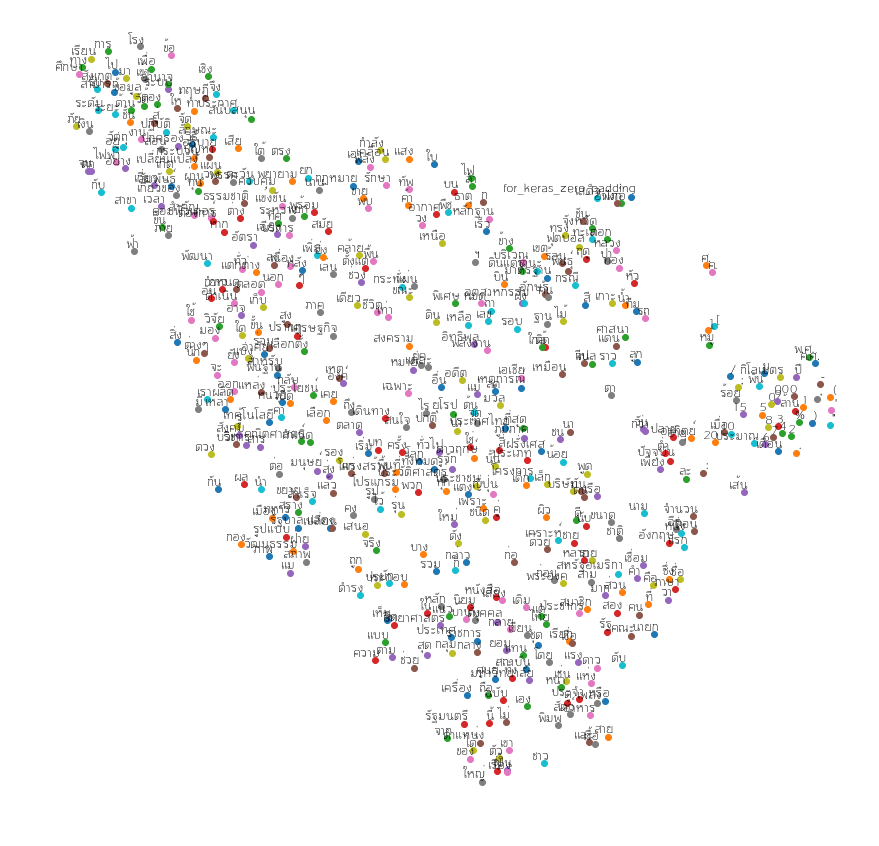

<Figure size 432x288 with 0 Axes>

In [40]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib as mpl

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=2500)
plot_only = 500 #only top 500 words
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

# Step 6: Extrinsic Evaluation

## <font color='blue'>Homework Question6:</font>
<font color='blue'>
Use the word embeddings from the skip-gram model as pre-trained weights in a classification model. Compare the result the with the same classification model that does not use the pre-trained weights. 
</font>


In [41]:
all_news_filepath = glob.glob('/media/kok/New Volume/NLP/nlp_2019/HW5/corpora/BEST2010/training_set/news/*.txt')
all_novel_filepath = glob.glob('/media/kok/New Volume/NLP/nlp_2019/HW5/corpora/BEST2010/training_set/novel/*.txt')
all_article_filepath = glob.glob('/media/kok/New Volume/NLP/nlp_2019/HW5/corpora/BEST2010/training_set/article/*.txt')
all_encyclopedia_filepath = glob.glob('/media/kok/New Volume/NLP/nlp_2019/HW5/corpora/BEST2010/training_set/encyclopedia/*.txt')

In [42]:
#preparing data for the classificaiton model
#In your homework, we will only use the first 2000 words in each text file
#any text file that has less than 2000 words will be padded
#reason:just to make this homework feasible under limited time and resource
max_length = 2000
def word_to_index(word):
    if word in dictionary:
        return dictionary[word]
    else:#if unknown
        return dictionary["UNK"]


def prep_data():
    input_text = list()
    for textfile_path in [all_news_filepath, all_novel_filepath, all_article_filepath, all_encyclopedia_filepath]:
        for input_file in textfile_path:
            f = open(input_file,"r") #open file with name of "*.txt"
            text = re.sub(r'\|', ' ', f.read()) # replace separation symbol with white space           
            text = re.sub(r'<\W?\w+>', '', text)# remove <NE> </NE> <AB> </AB> tags
            text = text.split() #split() method without an argument splits on whitespace 
            indexed_text = list(map(lambda x:word_to_index(x), text[:max_length])) #map raw word string to its index   
            if 'news' in input_file:
                input_text.append([indexed_text,0]) 
            elif 'novel' in input_file:
                input_text.append([indexed_text,1]) 
            elif 'article' in input_file:
                input_text.append([indexed_text,2]) 
            elif 'encyclopedia' in input_file:
                input_text.append([indexed_text,3]) 
            
            f.close()
    random.shuffle(input_text)
    return input_text

input_data = prep_data()
train_data = input_data[:int(len(input_data)*0.6)]
val_data = input_data[int(len(input_data)*0.6):int(len(input_data)*0.8)]
test_data = input_data[int(len(input_data)*0.8):]

train_input = [data[0] for data in train_data]
train_input = sequence.pad_sequences(train_input, maxlen=max_length) #padding
train_target = [data[1] for data in train_data]
train_target=to_categorical(train_target, num_classes=4)



val_input = [data[0] for data in val_data]
val_input = sequence.pad_sequences(val_input, maxlen=max_length) #padding
val_target = [data[1] for data in val_data]
val_target=to_categorical(val_target, num_classes=4)

test_input = [data[0] for data in test_data]
test_input = sequence.pad_sequences(test_input, maxlen=max_length) #padding
test_target = [data[1] for data in test_data]
test_target=to_categorical(test_target, num_classes=4)

del input_data, val_data,train_data, test_data

In [46]:
weigth_emd = SkipGram.get_weights()[0]

In [47]:
#the classification model
#TO DO#6 find out how to initialize your embedding layer with pre-trained weights, evaluate and observe
#don't forget to compare it with the same model that does not use pre-trained weights
#you can use your own model too! and feel free to customize this model as you wish
cls_model = Sequential()
cls_model.add(Embedding(len(dictionary), 32,weights=[weigth_emd], input_length=max_length,mask_zero=True,trainable=False))
cls_model.add(GRU(32))
cls_model.add(Dropout(0.5))
cls_model.add(Dense(4, activation='softmax'))
opt=Adam(lr=0.01)
cls_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
cls_model.summary()
print('Train...')
cls_model.fit(train_input, train_target,
          epochs=20,
          validation_data=[val_input, val_target])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 2000, 32)          846496    
_________________________________________________________________
gru_5 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 4)                 132       
Total params: 852,868
Trainable params: 6,372
Non-trainable params: 846,496
_________________________________________________________________
Train...
Train on 303 samples, validate on 101 samples
Epoch 1/20
303/303 [==============================] - 33s 109ms/step - loss: 1.4065 - acc: 0.3267 - val_loss: 1.3507 - val_acc: 0.4059
Epoch 2/20
303/303 [==============================] - 37s 122ms/step - los

In [52]:
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
y_pred = cls_model.predict(test_input)
y_pred = np.argmax(y_pred,axis=1)
y_real = np.argmax(test_target,axis=1)

print(f1_score(y_real,y_pred,average="macro"))
print(accuracy_score(y_real,y_pred))
print(precision_score(y_real,y_pred,average="macro"))
print(recall_score(y_real,y_pred,average="macro"))

0.38676916833166836
0.46078431372549017
0.5814393939393939
0.3887397294655359


In [53]:
#the classification model
#TO DO#6 find out how to initialize your embedding layer with pre-trained weights, evaluate and observe
#don't forget to compare it with the same model that does not use pre-trained weights
#you can use your own model too! and feel free to customize this model as you wish
cls_model = Sequential()
cls_model.add(Embedding(len(dictionary), 32,weights=[weigth_emd], input_length=max_length,mask_zero=True,trainable=True))
cls_model.add(GRU(32))
cls_model.add(Dropout(0.5))
cls_model.add(Dense(4, activation='softmax'))
opt=Adam(lr=0.01)
cls_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
cls_model.summary()
print('Train...')
cls_model.fit(train_input, train_target,
          epochs=20,
          validation_data=[val_input, val_target])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 2000, 32)          846496    
_________________________________________________________________
gru_6 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 4)                 132       
Total params: 852,868
Trainable params: 852,868
Non-trainable params: 0
_________________________________________________________________
Train...
Train on 303 samples, validate on 101 samples
Epoch 1/20
303/303 [==============================] - 36s 120ms/step - loss: 1.4256 - acc: 0.3399 - val_loss: 1.3061 - val_acc: 0.4059
Epoch 2/20
303/303 [==============================] - 43s 142ms/step - loss: 1

In [54]:
y_pred = cls_model.predict(test_input)
y_pred = np.argmax(y_pred,axis=1)
y_real = np.argmax(test_target,axis=1)

print(f1_score(y_real,y_pred,average="macro"))
print(accuracy_score(y_real,y_pred))
print(precision_score(y_real,y_pred,average="macro"))
print(recall_score(y_real,y_pred,average="macro"))

0.6950967322942302
0.7254901960784313
0.7093836396161978
0.6968376000634066
